Install Detectron2

Run a pre-trained detectron2 model

We first download an image from the COCO dataset:

In [2]:
#---> pip install torch torchvision torchaudio
#---> python -m pip install pyyaml==5.1

import sys, os, distutils.core
print(sys.executable)
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
#---> python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

/home/pauloarbu/phpy/bin/python


In [3]:
import torch, detectron2

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
# Test CUDA device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")


#---> nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print(f"detectron2 version: {detectron2.__version__}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
GPU device: NVIDIA GeForce RTX 4060
torch:  2.6 ; cuda:  cu124
detectron2 version: 0.6


Basic setup

In [4]:
# Setup detectron2 logger
import detectron2
import matplotlib.pyplot as plt
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


print(f"OpenCV version: {cv2.__version__}")


OpenCV version: 4.11.0


Train on a custom dataset

In this section, we train an existing detectron2 model on a custom dataset in a new format.

We use the blade defect segmentation dataset which only has one class: defect. We'll train a defect segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.


------- BEGINNING OF MODEL TRAINING: SEGMENT AND LOCATE BLADE DEFECTS ----------

0. Scan Annotation Files to Extract Defect Categories


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Known defect types: ['hole', 'scratch', 'crack', 'erosion', 'crazing', 'scratch_set']

Healthy directory exists: True
Faulty directory exists: True
Found 59 XML annotation files in /home/pauloarbu/Faulty_annot
File: Areial_Faulty18.xml - Categories: ['scratch', 'scratch', 'scratch']
File: Faulty_Train1393.xml - Categories: ['hole', 'erosion']
File: Areial_Faulty23.xml - Categories: ['hole', 'crazing', 'scratch', 'scratch_set', 'scratch', 'erosion']
File: Faulty_Train1321.xml - Categories: ['hole']
File: Areial_Faulty39.xml - Categories: ['hole']

Processed 59 files, found categories in 59 files

Found defect categories:
1. hole: 37 instances
2. scratch: 60 instances
3. crack: 40 instances
4. erosion: 26 instances
5. crazing: 5 instances
6. scratch_set: 9 instances


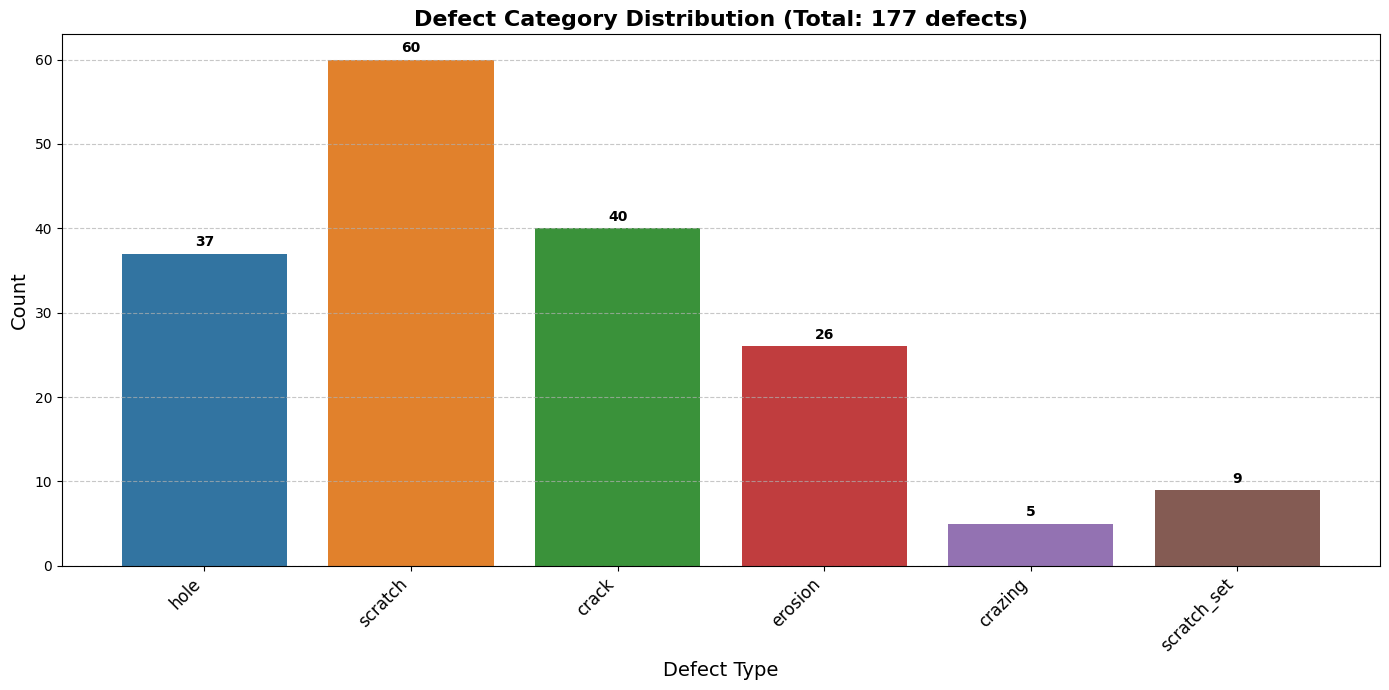

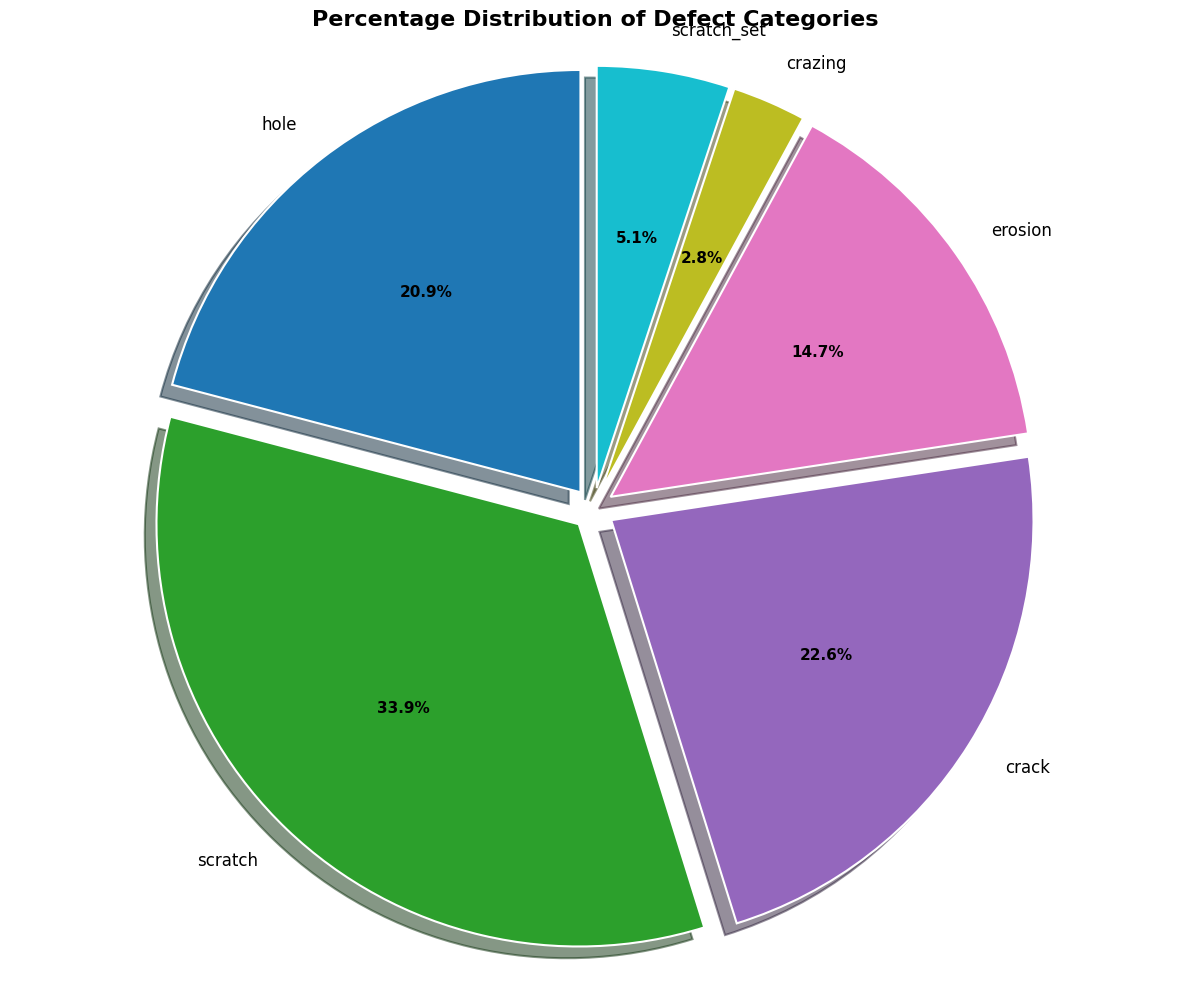


Final category list: ['healthy', 'hole', 'scratch', 'crack', 'erosion', 'crazing', 'scratch_set']

Dataset Statistics:
  Healthy images: 81
  Faulty images: 59
  Annotation files: 59
  Annotation coverage: 100.0% of faulty images


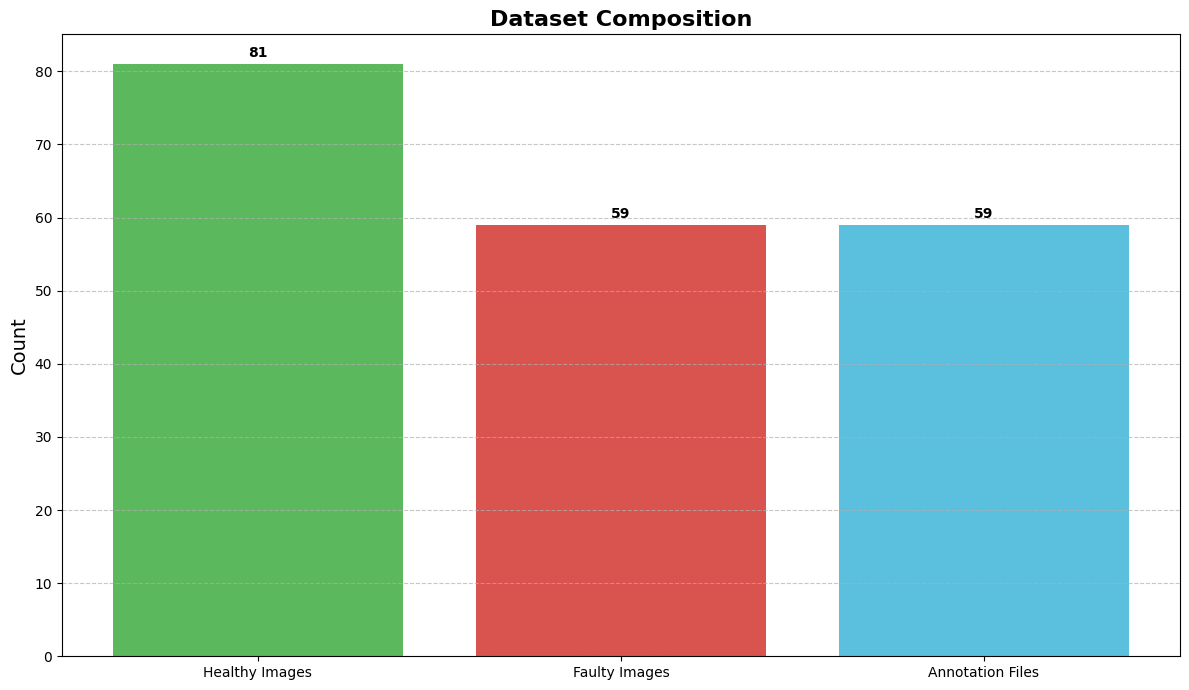


Examining sample annotation content:
Sample annotation file: Areial_Faulty18.xml
Referenced image: Areial_Faulty18.jpg
Contains 3 annotated defects:
  1. scratch: bbox=[259, 103, 264, 122]
  2. scratch: bbox=[52, 207, 65, 234]
  3. scratch: bbox=[30, 183, 42, 210]

Converting XML annotations to COCO format...
Converting 47 XML annotations to COCO format...

Conversion summary:
  Successful files: 46
  Failed files: 1
  Total images in COCO format: 46
  Total annotations in COCO format: 137
  COCO JSON file saved to: /home/pauloarbu/coco_annotations/blade_defects_train.json
Converting 12 XML annotations to COCO format...
Processed 12/12 files...

Conversion summary:
  Successful files: 12
  Failed files: 0
  Total images in COCO format: 12
  Total annotations in COCO format: 37
  COCO JSON file saved to: /home/pauloarbu/coco_annotations/blade_defects_val.json

Created COCO datasets:
  Training: /home/pauloarbu/coco_annotations/blade_defects_train.json (47 images)
  Validation: /home/pa

In [5]:
# Install required packages
!pip install detectron2 -U
import os
import xml.etree.ElementTree as ET
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import json
import cv2
from datetime import datetime

# Define known defect types from the provided information
KNOWN_DEFECT_TYPES = ["hole", "scratch", "crack", "erosion", "crazing", "scratch_set"]
print(f"Known defect types: {KNOWN_DEFECT_TYPES}")

# Define paths with correct spelling
healthy_dir = "/home/pauloarbu/Healthy_no_annot"  
faulty_dir = "/home/pauloarbu/Faulty_annot"

# Verify the directories exist
print(f"\nHealthy directory exists: {os.path.exists(healthy_dir)}")
print(f"Faulty directory exists: {os.path.exists(faulty_dir)}")

# Find all XML annotation files in the faulty blades directory
annotation_files = []
if os.path.exists(faulty_dir):
    for ext in ["*.xml"]:
        annotation_files.extend(glob.glob(os.path.join(faulty_dir, ext)))
    print(f"Found {len(annotation_files)} XML annotation files in {faulty_dir}")
else:
    print(f"ERROR: Faulty directory '{faulty_dir}' does not exist!")

# Function to extract defect categories from XML annotation files
def extract_defect_categories(annotation_files):
    all_categories = []
    processed_files = 0
    files_with_categories = 0
    
    for ann_file in annotation_files:
        try:
            # Parse the XML file
            tree = ET.parse(ann_file)
            root = tree.getroot()
            
            # Extract categories (class names) from the XML
            file_categories = []
            
            # In LabelImg XML format, each 'object' has a 'name' that specifies the class
            for obj in root.findall('./object'):
                name_elem = obj.find('name')
                if name_elem is not None:
                    category = name_elem.text
                    file_categories.append(category)
            
            # Log results for debugging
            processed_files += 1
            if file_categories:
                files_with_categories += 1
                all_categories.extend(file_categories)
                
                # Print details for the first few files
                if processed_files <= 5:
                    file_name = os.path.basename(ann_file)
                    print(f"File: {file_name} - Categories: {file_categories}")
            
            # Progress update every 100 files
            if processed_files % 100 == 0:
                print(f"Processed {processed_files}/{len(annotation_files)} files...")
                
        except Exception as e:
            print(f"Error processing {os.path.basename(ann_file)}: {e}")
    
    print(f"\nProcessed {processed_files} files, found categories in {files_with_categories} files")
    return all_categories

# Function to convert XML annotations to COCO format
def convert_xml_to_coco(xml_files, image_dir, categories, output_json_path):
    """
    Convert XML annotations in LabelImg format to COCO JSON format
    
    Args:
        xml_files: List of XML annotation file paths
        image_dir: Directory containing the images
        categories: List of defect categories
        output_json_path: Path to save the output COCO JSON file
        
    Returns:
        Path to the created COCO JSON file
    """
    # Initialize COCO JSON structure
    coco_output = {
        "info": {
            "description": "Blade Defect Dataset",
            "url": "",
            "version": "1.0",
            "year": datetime.now().year,
            "contributor": "",
            "date_created": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        },
        "licenses": [
            {
                "id": 1,
                "name": "Unknown",
                "url": ""
            }
        ],
        "images": [],
        "annotations": [],
        "categories": []
    }
    
    # Create category mapping (excluding "healthy" which is not a defect class)
    for i, category in enumerate(categories):
        if category.lower() != "healthy":
            coco_output["categories"].append({
                "id": i,
                "name": category,
                "supercategory": "defect"
            })
    
    # Create a lookup from category name to ID
    cat_name_to_id = {cat["name"]: cat["id"] for cat in coco_output["categories"]}
    
    # Variables to track progress
    img_id = 0
    ann_id = 0
    processed_files = 0
    successful_files = 0
    failed_files = 0
    
    print(f"Converting {len(xml_files)} XML annotations to COCO format...")
    
    # Process each XML file
    for xml_file in xml_files:
        try:
            # Parse XML
            tree = ET.parse(xml_file)
            root = tree.getroot()
            
            # Get image filename
            filename_elem = root.find("filename")
            if filename_elem is None:
                print(f"Warning: No filename in {os.path.basename(xml_file)}")
                failed_files += 1
                continue
                
            image_filename = filename_elem.text
            
            # Find the image file
            image_path = os.path.join(image_dir, image_filename)
            if not os.path.exists(image_path):
                # Try different extensions
                base_name = os.path.splitext(image_filename)[0]
                found = False
                for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
                    alt_path = os.path.join(image_dir, base_name + ext)
                    if os.path.exists(alt_path):
                        image_path = alt_path
                        image_filename = base_name + ext
                        found = True
                        break
                        
                if not found:
                    print(f"Warning: Image file {image_filename} not found for {os.path.basename(xml_file)}")
                    failed_files += 1
                    continue
            
            # Get image dimensions
            try:
                img = cv2.imread(image_path)
                if img is None:
                    # Try to get dimensions from XML
                    size_elem = root.find("size")
                    if size_elem is not None:
                        width = int(size_elem.find("width").text)
                        height = int(size_elem.find("height").text)
                    else:
                        print(f"Warning: Cannot determine dimensions for {image_filename}")
                        failed_files += 1
                        continue
                else:
                    height, width = img.shape[:2]
            except Exception as e:
                print(f"Error reading image {image_filename}: {e}")
                failed_files += 1
                continue
            
            # Add image to COCO structure
            coco_image = {
                "id": img_id,
                "file_name": image_filename,
                "width": width,
                "height": height,
                "license": 1
            }
            coco_output["images"].append(coco_image)
            
            # Process objects (annotations)
            for obj in root.findall('./object'):
                name_elem = obj.find('name')
                if name_elem is None:
                    continue
                    
                category = name_elem.text
                if category not in cat_name_to_id:
                    print(f"Warning: Category '{category}' not in predefined categories, skipping annotation")
                    continue
                
                category_id = cat_name_to_id[category]
                
                # Get bounding box
                bbox_elem = obj.find('bndbox')
                if bbox_elem is None:
                    continue
                    
                # Parse bbox coordinates
                xmin = float(bbox_elem.find('xmin').text)
                ymin = float(bbox_elem.find('ymin').text)
                xmax = float(bbox_elem.find('xmax').text)
                ymax = float(bbox_elem.find('ymax').text)
                
                # COCO format uses [x,y,width,height] for bbox
                bbox_width = xmax - xmin
                bbox_height = ymax - ymin
                
                # Add annotation to COCO structure
                coco_annotation = {
                    "id": ann_id,
                    "image_id": img_id,
                    "category_id": category_id,
                    "bbox": [xmin, ymin, bbox_width, bbox_height],
                    "area": bbox_width * bbox_height,
                    "segmentation": [],  # No segmentation for this dataset
                    "iscrowd": 0
                }
                coco_output["annotations"].append(coco_annotation)
                ann_id += 1
            
            img_id += 1
            successful_files += 1
            
            # Progress update
            processed_files += 1
            if processed_files % 100 == 0 or processed_files == len(xml_files):
                print(f"Processed {processed_files}/{len(xml_files)} files...")
                
        except Exception as e:
            print(f"Error processing {os.path.basename(xml_file)}: {e}")
            failed_files += 1
    
    # Write to JSON file
    with open(output_json_path, 'w') as f:
        json.dump(coco_output, f, indent=2)
    
    print(f"\nConversion summary:")
    print(f"  Successful files: {successful_files}")
    print(f"  Failed files: {failed_files}")
    print(f"  Total images in COCO format: {len(coco_output['images'])}")
    print(f"  Total annotations in COCO format: {len(coco_output['annotations'])}")
    print(f"  COCO JSON file saved to: {output_json_path}")
    
    return output_json_path

if annotation_files:
    # Extract all categories from annotation files
    all_defect_categories = extract_defect_categories(annotation_files)

    # Analyze the categories found
    category_counts = Counter(all_defect_categories)
    
    # Ensure all known defect types are included in the counter with at least 0 count
    for defect_type in KNOWN_DEFECT_TYPES:
        if defect_type not in category_counts:
            category_counts[defect_type] = 0
    
    # Sort categories to match the provided order as much as possible
    sorted_categories = []
    # First add the known categories in their specified order
    for cat in KNOWN_DEFECT_TYPES:
        if cat in category_counts:
            sorted_categories.append(cat)
    
    # Then add any additional categories found in the data
    for cat in category_counts:
        if cat not in sorted_categories:
            sorted_categories.append(cat)
    
    print(f"\nFound defect categories:")
    for i, category in enumerate(sorted_categories):
        count = category_counts[category]
        print(f"{i+1}. {category}: {count} instances")

    # Visualize category distribution - BAR GRAPH
    plt.figure(figsize=(14, 7))
    
    # Use the sorted categories for consistent ordering
    bars = plt.bar(sorted_categories, [category_counts[cat] for cat in sorted_categories],
                  color=['#3274A1', '#E1812C', '#3A923A', '#C03D3E', '#9372B2', '#845B53'])
    
    # Add count labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')
    
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.title('Defect Category Distribution', fontsize=16, fontweight='bold')
    plt.xlabel('Defect Type', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add total count in the title
    total_defects = sum(category_counts.values())
    plt.title(f'Defect Category Distribution (Total: {total_defects} defects)', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

    # PIE CHART for percentage distribution
    plt.figure(figsize=(12, 10))
    
    # Filter out categories with 0 count for the pie chart
    pie_categories = [cat for cat in sorted_categories if category_counts[cat] > 0]
    pie_counts = [category_counts[cat] for cat in pie_categories]
    
    # Create custom colors
    colors = plt.cm.tab10(np.linspace(0, 1, len(pie_categories)))
    
    # Create pie chart with shadow effect
    wedges, texts, autotexts = plt.pie(
        pie_counts, 
        labels=pie_categories,
        autopct='%1.1f%%',
        startangle=90,
        shadow=True,
        colors=colors,
        explode=[0.05] * len(pie_categories),  # Slight explode effect
        wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
    )
    
    # Style the text
    for text in texts:
        text.set_fontsize(12)
    for autotext in autotexts:
        autotext.set_fontsize(11)
        autotext.set_fontweight('bold')
    
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.title('Percentage Distribution of Defect Categories', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Save the categories for later use
    DEFECT_TYPES = ["healthy"] + sorted_categories  # Add "healthy" as the first category
    print(f"\nFinal category list: {DEFECT_TYPES}")

    # Count images in directories (if they exist)
    healthy_images = []
    if os.path.exists(healthy_dir):
        for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
            healthy_images.extend(glob.glob(os.path.join(healthy_dir, f"*{ext}")))

    faulty_images = []
    if os.path.exists(faulty_dir):
        for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
            faulty_images.extend(glob.glob(os.path.join(faulty_dir, f"*{ext}")))

    print(f"\nDataset Statistics:")
    print(f"  Healthy images: {len(healthy_images)}")
    print(f"  Faulty images: {len(faulty_images)}")
    print(f"  Annotation files: {len(annotation_files)}")

    # Calculate the image-to-annotation ratio
    if len(faulty_images) > 0:
        print(f"  Annotation coverage: {len(annotation_files)/len(faulty_images)*100:.1f}% of faulty images")

    # Create bar graph for dataset composition
    plt.figure(figsize=(12, 7))
    dataset_bars = plt.bar(['Healthy Images', 'Faulty Images', 'Annotation Files'], 
            [len(healthy_images), len(faulty_images), len(annotation_files)],
            color=['#5cb85c', '#d9534f', '#5bc0de'])

    # Add count labels on top of each bar
    for bar in dataset_bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')

    plt.title('Dataset Composition', fontsize=16, fontweight='bold')
    plt.ylabel('Count', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Let's examine a few sample annotations in more detail
    print("\nExamining sample annotation content:")
    sample_file = annotation_files[0]
    try:
        tree = ET.parse(sample_file)
        root = tree.getroot()
        filename = root.find("filename").text if root.find("filename") is not None else "unknown"
        
        print(f"Sample annotation file: {os.path.basename(sample_file)}")
        print(f"Referenced image: {filename}")
        
        objects = root.findall('./object')
        print(f"Contains {len(objects)} annotated defects:")
        
        for i, obj in enumerate(objects):
            name = obj.find('name').text if obj.find('name') is not None else "unknown"
            bbox = obj.find('bndbox')
            if bbox is not None:
                xmin = bbox.find('xmin').text
                ymin = bbox.find('ymin').text
                xmax = bbox.find('xmax').text
                ymax = bbox.find('ymax').text
                print(f"  {i+1}. {name}: bbox=[{xmin}, {ymin}, {xmax}, {ymax}]")
            else:
                print(f"  {i+1}. {name}: no bounding box")
    except Exception as e:
        print(f"Error examining sample file: {e}")
    
    # Convert XML annotations to COCO format
    print("\nConverting XML annotations to COCO format...")
    coco_output_dir = os.path.join(os.path.dirname(faulty_dir), "coco_annotations")
    os.makedirs(coco_output_dir, exist_ok=True)
    
    # Create separate files for train and validation
    # For training: use 80% of the data
    train_xml_files = annotation_files[:int(0.8 * len(annotation_files))]
    val_xml_files = annotation_files[int(0.8 * len(annotation_files)):]
    
    # Convert and save both datasets
    train_coco_path = os.path.join(coco_output_dir, "blade_defects_train.json")
    val_coco_path = os.path.join(coco_output_dir, "blade_defects_val.json")
    
    # Convert training set
    train_coco_file = convert_xml_to_coco(
        train_xml_files, 
        faulty_dir, 
        DEFECT_TYPES, 
        train_coco_path
    )
    
    # Convert validation set if there are enough files
    if len(val_xml_files) > 0:
        val_coco_file = convert_xml_to_coco(
            val_xml_files, 
            faulty_dir, 
            DEFECT_TYPES, 
            val_coco_path
        )
        print(f"\nCreated COCO datasets:")
        print(f"  Training: {train_coco_file} ({len(train_xml_files)} images)")
        print(f"  Validation: {val_coco_file} ({len(val_xml_files)} images)")
    else:
        print(f"\nCreated COCO dataset:")
        print(f"  Training only: {train_coco_file} ({len(train_xml_files)} images)")
        print(f"  No validation set created (insufficient data)")
        
    print("\nYou can now use these COCO JSON files with Detectron2 for training")
    print("Example dataset registration code:")
    print("```python")
    print("from detectron2.data import DatasetCatalog, MetadataCatalog")
    print("from detectron2.data.datasets import register_coco_instances")
    print(f'register_coco_instances("blade_train", {{}}, "{train_coco_path}", "{faulty_dir}")')
    if len(val_xml_files) > 0:
        print(f'register_coco_instances("blade_val", {{}}, "{val_coco_path}", "{faulty_dir}")')
    print("```")
    
else:
    print("\nNo annotation files found. Cannot convert to COCO format.")
    DEFECT_TYPES = ["healthy"] + KNOWN_DEFECT_TYPES
    print(f"Using pre-defined defect types: {DEFECT_TYPES}")

1. Dataset Loading Function

Found training COCO annotations: /home/pauloarbu/coco_annotations/blade_defects_train.json
Found validation COCO annotations: /home/pauloarbu/coco_annotations/blade_defects_val.json
Extracted categories from COCO file: ['healthy', 'hole', 'scratch', 'crack', 'erosion', 'crazing', 'scratch_set']

Clearing any existing dataset registrations...
Registering blade defect datasets...

Dataset Statistics:
[05/08 14:36:10 d2.data.datasets.coco]: Loaded 46 images in COCO format from /home/pauloarbu/coco_annotations/blade_defects_train.json
Found 81 healthy blade images
Using 64 healthy images for training
Combined dataset: 46 defect images + 64 healthy images = 110 total images
[05/08 14:36:10 d2.data.datasets.coco]: Loaded 12 images in COCO format from /home/pauloarbu/coco_annotations/blade_defects_val.json
Found 81 healthy blade images
Using 17 healthy images for validation
Combined dataset: 12 defect images + 17 healthy images = 29 total images
Training set: 110 images (64 healthy, 46 with d

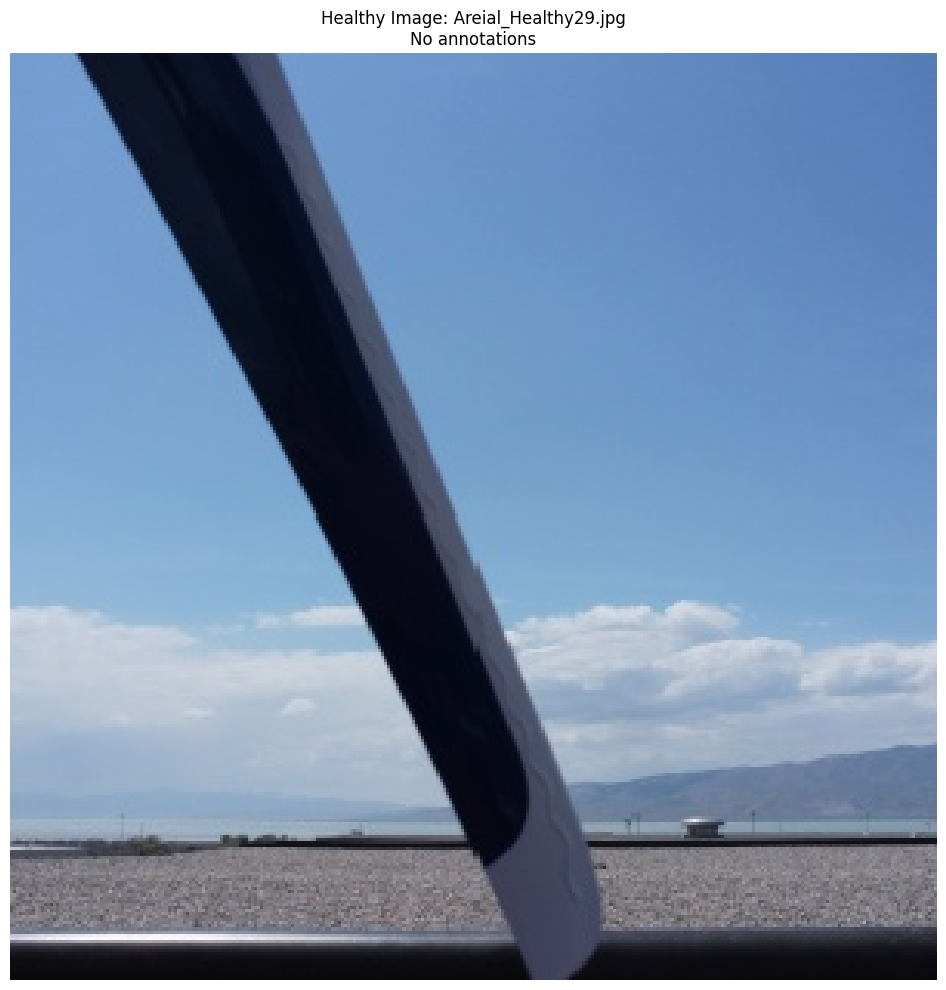

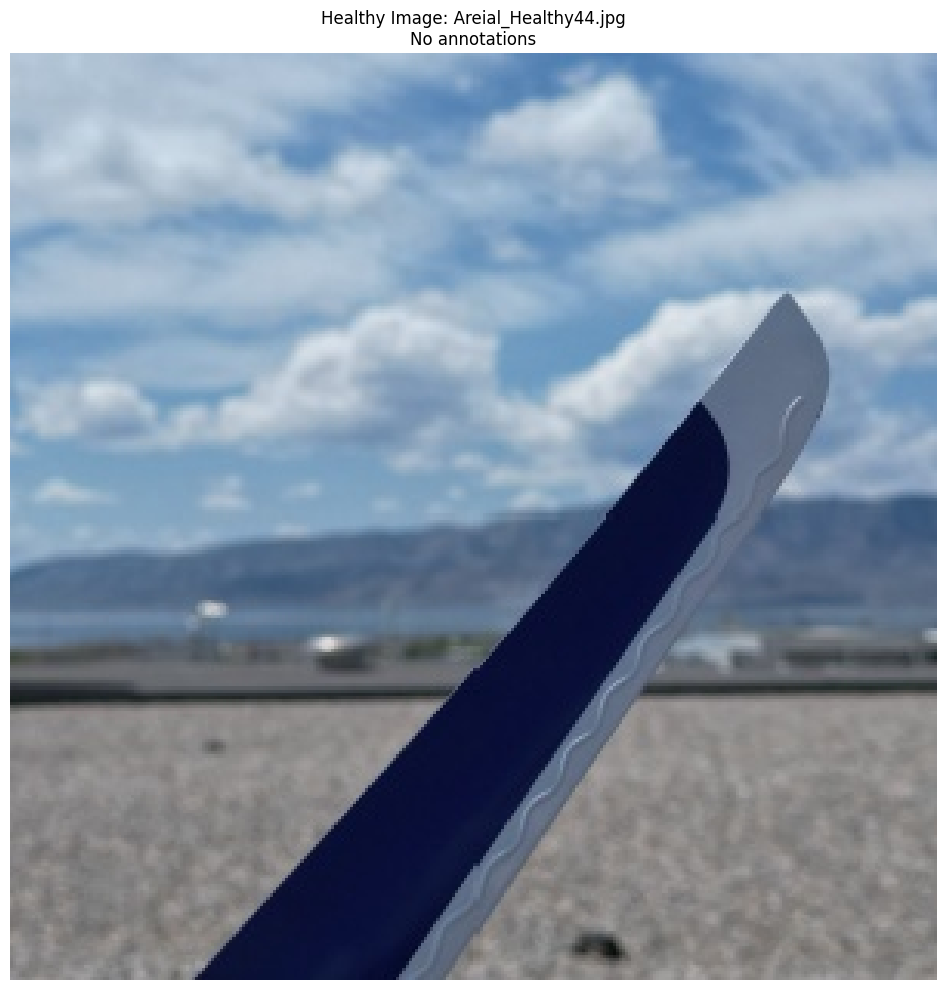

[05/08 14:36:10 d2.data.datasets.coco]: Loaded 46 images in COCO format from /home/pauloarbu/coco_annotations/blade_defects_train.json
Found 81 healthy blade images
Using 64 healthy images for training
Combined dataset: 46 defect images + 64 healthy images = 110 total images


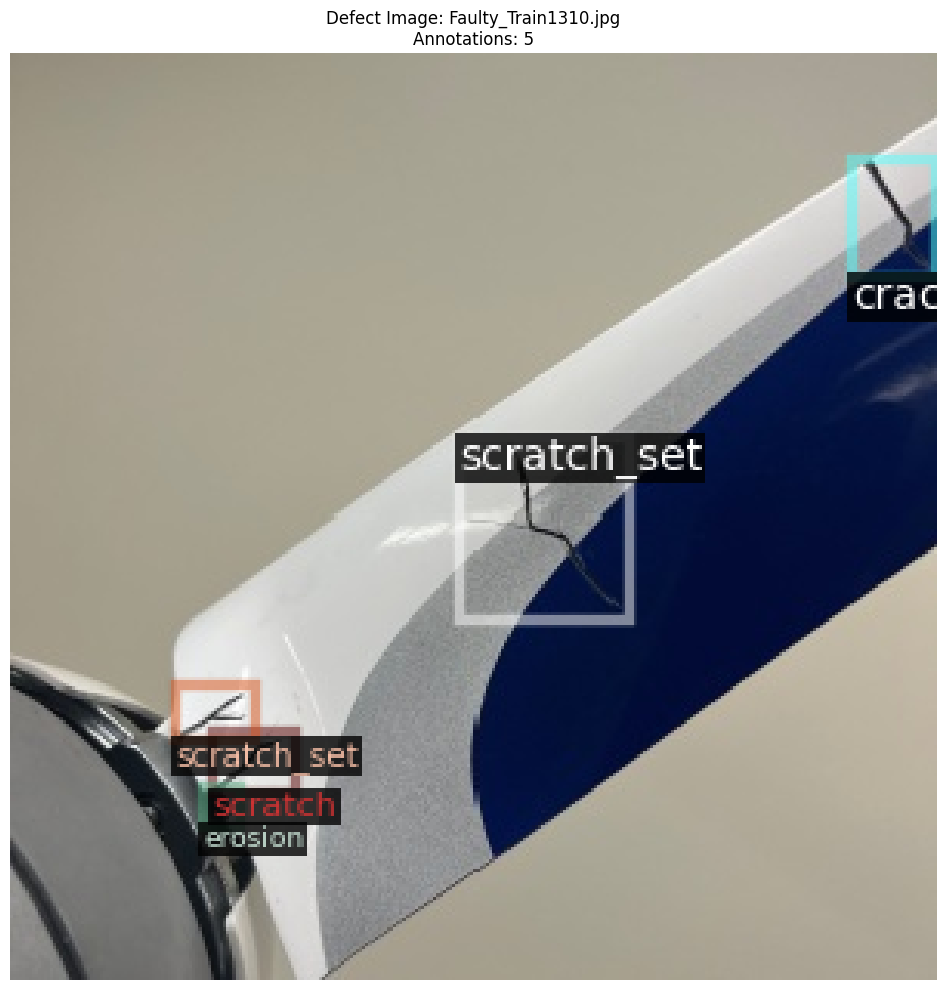

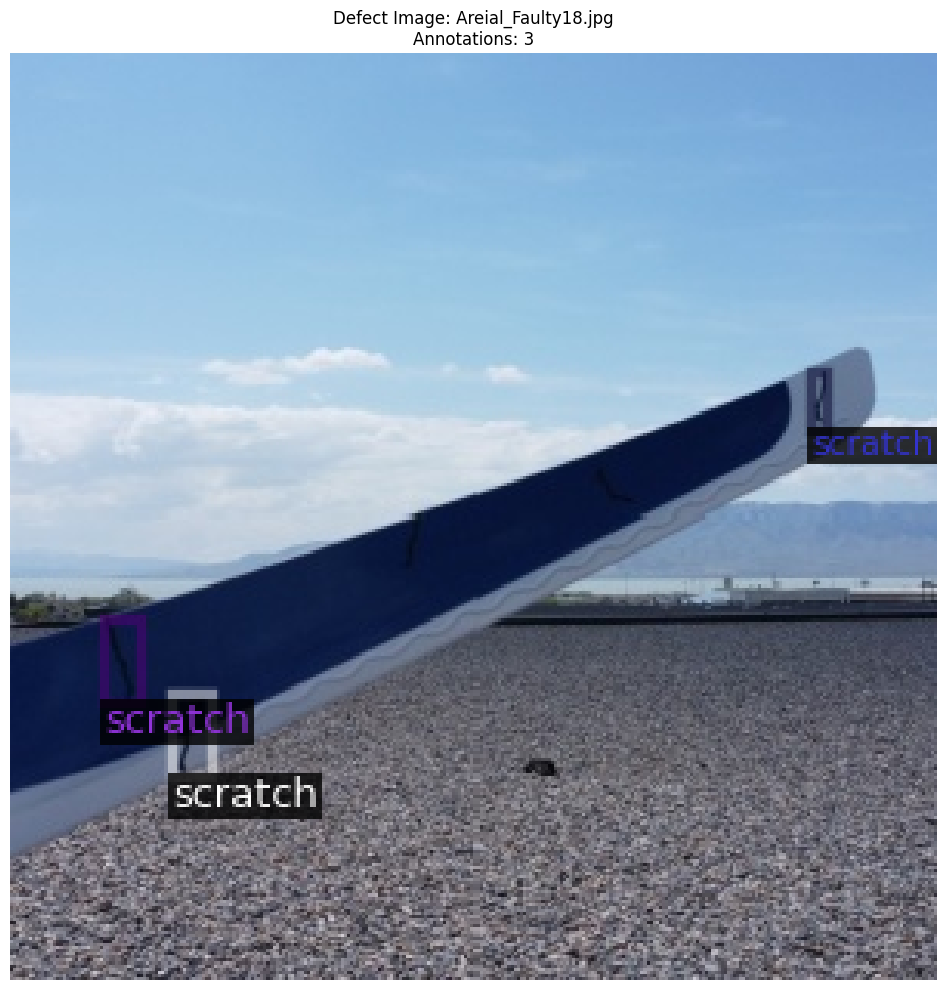

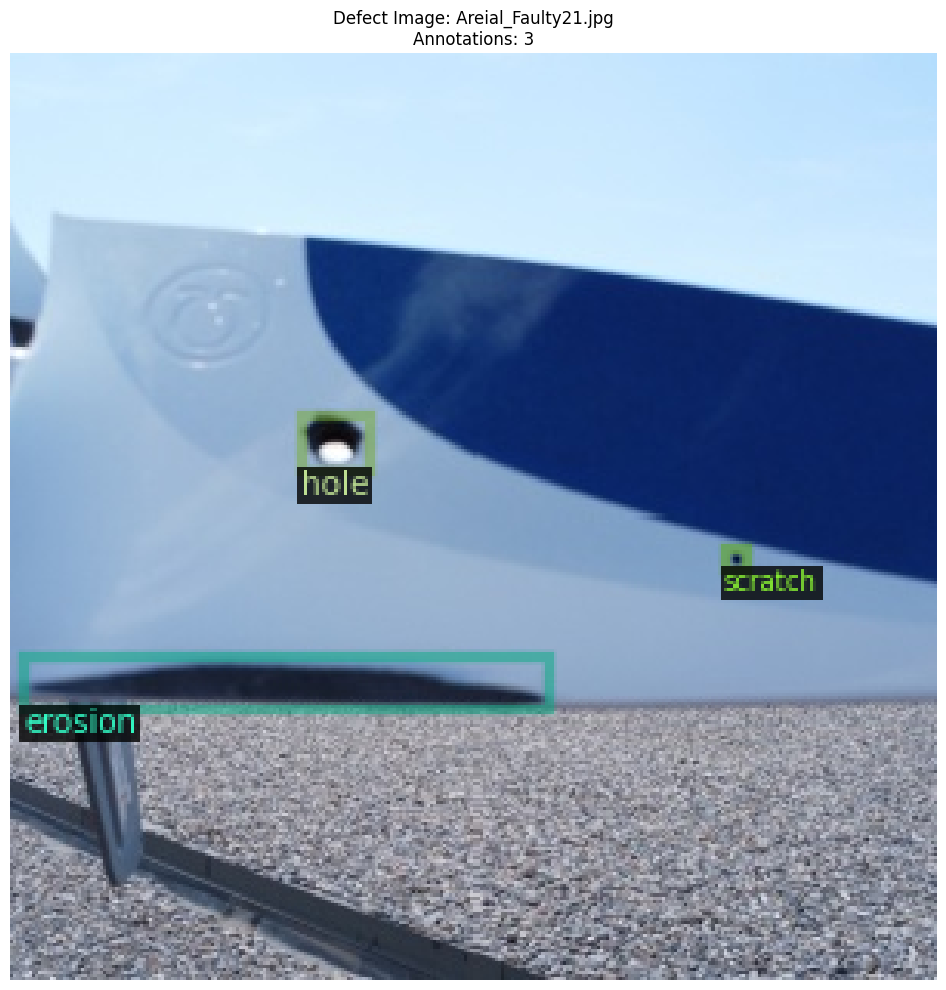

In [6]:
# Import necessary libraries
import os
import random
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode

# Helper function to safely unregister datasets if they exist
def safe_register(name, func):
    if name in DatasetCatalog:
        DatasetCatalog.remove(name)
    # For MetadataCatalog, we can't directly remove entries, but we can overwrite them later
    DatasetCatalog.register(name, func)

# Define paths
healthy_dir = "/home/pauloarbu/Healthy_no_annot"
faulty_dir = "/home/pauloarbu/Faulty_annot"
coco_dir = "/home/pauloarbu/coco_annotations"  # Updated based on your actual path
train_coco_path = os.path.join(coco_dir, "blade_defects_train.json")
val_coco_path = os.path.join(coco_dir, "blade_defects_val.json")

# Verify that the COCO annotation files exist
if not os.path.exists(train_coco_path):
    print(f"ERROR: Training COCO file not found: {train_coco_path}")
    print("Please run the XML to COCO conversion cell first.")
else:
    print(f"Found training COCO annotations: {train_coco_path}")

val_exists = os.path.exists(val_coco_path)
if val_exists:
    print(f"Found validation COCO annotations: {val_coco_path}")
else:
    print(f"Validation COCO file not found. Will create validation set from training data.")

# Define the defect categories (these should match those in your COCO file)
try:
    import json
    with open(train_coco_path, 'r') as f:
        coco_data = json.load(f)
    
    # Extract categories from COCO file
    defect_categories = ["healthy"]  # Start with healthy as category 0
    for cat in coco_data.get("categories", []):
        defect_categories.append(cat["name"])
    
    print(f"Extracted categories from COCO file: {defect_categories}")
except Exception as e:
    # Fallback to known categories if COCO file can't be read
    defect_categories = ["healthy", "hole", "scratch", "crack", "erosion", "crazing", "scratch_set"]
    print(f"Using default categories: {defect_categories}")

# Function to load healthy blade images (which aren't in the COCO file)
def get_healthy_blade_dicts(healthy_dir, is_train=True):
    """
    Load healthy blade images (which have no defect annotations)
    """
    dataset_dicts = []
    
    # Get all healthy images
    healthy_images = []
    for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
        healthy_images.extend(glob.glob(os.path.join(healthy_dir, f"*{ext}")))
    
    print(f"Found {len(healthy_images)} healthy blade images")
    
    # Split images between train and validation
    if not is_train:
        # Use last 20% for validation
        start_idx = int(len(healthy_images) * 0.8)
        healthy_images = healthy_images[start_idx:]
    else:
        # Use first 80% for training
        end_idx = int(len(healthy_images) * 0.8)
        healthy_images = healthy_images[:end_idx]
    
    print(f"Using {len(healthy_images)} healthy images for {'training' if is_train else 'validation'}")
    
    # Process each image
    for idx, img_path in enumerate(healthy_images):
        try:
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Could not read healthy image {img_path}")
                continue
                
            height, width = img.shape[:2]
            
            # Create record for this image
            record = {
                "file_name": img_path,
                "image_id": idx + 10000,  # Use high IDs to avoid conflicts with COCO
                "height": height,
                "width": width,
                "annotations": [],  # No defect annotations
                "is_healthy": True  # Custom field to track healthy images
            }
            
            dataset_dicts.append(record)
        except Exception as e:
            print(f"Error processing healthy image {img_path}: {e}")
    
    return dataset_dicts

# Function to combine COCO defect data with healthy images
def get_combined_dataset_dicts(dataset_name):
    """
    Combines defect data from COCO format with healthy blade images
    """
    # Get defect images from COCO dataset
    defect_dicts = DatasetCatalog.get(dataset_name)
    
    # Get healthy images
    is_train = "train" in dataset_name
    healthy_dicts = get_healthy_blade_dicts(healthy_dir, is_train=is_train)
    
    # Mark defect images as not healthy
    for d in defect_dicts:
        d["is_healthy"] = False
    
    # Combine the datasets
    combined_dicts = defect_dicts + healthy_dicts
    
    print(f"Combined dataset: {len(defect_dicts)} defect images + {len(healthy_dicts)} healthy images = {len(combined_dicts)} total images")
    return combined_dicts

# First, clear any existing registrations to avoid errors
print("\nClearing any existing dataset registrations...")
for dataset_name in ["blade_defects_train", "blade_defects_val", "blade_full_train", "blade_full_val"]:
    if dataset_name in DatasetCatalog:
        DatasetCatalog.remove(dataset_name)
    # We'll just let MetadataCatalog be overwritten - no need to try to remove entries

# Register the COCO datasets
print("Registering blade defect datasets...")

# Register the faulty blades with COCO format
register_coco_instances(
    name="blade_defects_train",
    metadata={"thing_classes": defect_categories[1:]},  # Skip "healthy"
    json_file=train_coco_path,
    image_root=faulty_dir
)

# Register validation set if it exists
if val_exists:
    register_coco_instances(
        name="blade_defects_val",
        metadata={"thing_classes": defect_categories[1:]},  # Skip "healthy"
        json_file=val_coco_path,
        image_root=faulty_dir
    )

# Register the combined datasets (with healthy images) using safe_register
safe_register(
    "blade_full_train", 
    lambda: get_combined_dataset_dicts("blade_defects_train")
)

MetadataCatalog.get("blade_full_train").set(
    thing_classes=defect_categories[1:],  # Skip "healthy" for thing_classes
    thing_dataset_id_to_contiguous_id={i: i-1 for i in range(1, len(defect_categories))}
)

# Then for validation if it exists
if val_exists:
    safe_register(
        "blade_full_val", 
        lambda: get_combined_dataset_dicts("blade_defects_val")
    )
    
    MetadataCatalog.get("blade_full_val").set(
        thing_classes=defect_categories[1:],  # Skip "healthy" for thing_classes
        thing_dataset_id_to_contiguous_id={i: i-1 for i in range(1, len(defect_categories))}
    )
else:
    # If no validation set exists, create one from the training set (80/20 split)
    all_dicts = get_combined_dataset_dicts("blade_defects_train")
    random.seed(42)  # For reproducibility
    random.shuffle(all_dicts)
    
    split_idx = int(0.8 * len(all_dicts))
    train_dicts = all_dicts[:split_idx]
    val_dicts = all_dicts[split_idx:]
    
    # Re-register the training set
    safe_register(
        "blade_full_train", 
        lambda d=train_dicts: d
    )
    
    # Register the validation set
    safe_register(
        "blade_full_val", 
        lambda d=val_dicts: d
    )
    
    MetadataCatalog.get("blade_full_val").set(
        thing_classes=defect_categories[1:],  # Skip "healthy" for thing_classes
        thing_dataset_id_to_contiguous_id={i: i-1 for i in range(1, len(defect_categories))}
    )
    
    print(f"Created validation set with {len(val_dicts)} images from training data")

# Store metadata for later use
blade_metadata = MetadataCatalog.get("blade_full_train")

# Function to visualize dataset samples - FIXED
def visualize_dataset_samples(dataset_name, num_samples=3, show_healthy=True, show_defects=True):
    """
    Visualize random samples from the dataset
    """
    dataset_dicts = DatasetCatalog.get(dataset_name)
    metadata = MetadataCatalog.get(dataset_name)
    
    # Filter by healthy/defect if requested
    filtered_dicts = []
    if show_healthy:
        filtered_dicts.extend([d for d in dataset_dicts if d.get("is_healthy", False)])
    if show_defects:
        filtered_dicts.extend([d for d in dataset_dicts if not d.get("is_healthy", True)])
    
    if not filtered_dicts:
        print(f"No {'healthy' if show_healthy else ''} {'or' if show_healthy and show_defects else ''} {'defect' if show_defects else ''} images found in the dataset")
        return
    
    # Sample images
    samples = random.sample(filtered_dicts, min(num_samples, len(filtered_dicts)))
    
    for d in samples:
        img = cv2.imread(d["file_name"])
        if img is None:
            print(f"Warning: Could not read image {d['file_name']}")
            continue
            
        # Convert BGR to RGB for visualization
        img_rgb = img[:, :, ::-1]
        
        # Create visualization with annotations
        visualizer = Visualizer(img_rgb, metadata=metadata, scale=1.0)
        
        # Draw annotations if they exist
        if "annotations" in d and d["annotations"]:
            out = visualizer.draw_dataset_dict(d)
            title = f"Defect Image: {os.path.basename(d['file_name'])}"
            subtitle = f"Annotations: {len(d['annotations'])}"
        else:
            # For healthy images, draw the empty dict to get a visualization result
            out = visualizer.draw_dataset_dict(d)  # This will just draw the image with no boxes
            title = f"Healthy Image: {os.path.basename(d['file_name'])}"
            subtitle = "No annotations"
        
        # Display the image
        plt.figure(figsize=(12, 10))
        plt.imshow(out.get_image())
        plt.title(f"{title}\n{subtitle}")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

# Show dataset statistics
print("\nDataset Statistics:")
train_dicts = DatasetCatalog.get("blade_full_train")
val_dicts = DatasetCatalog.get("blade_full_val")

train_healthy = sum(1 for d in train_dicts if d.get("is_healthy", False))
train_defect = len(train_dicts) - train_healthy

val_healthy = sum(1 for d in val_dicts if d.get("is_healthy", False))
val_defect = len(val_dicts) - val_healthy

print(f"Training set: {len(train_dicts)} images ({train_healthy} healthy, {train_defect} with defects)")
print(f"Validation set: {len(val_dicts)} images ({val_healthy} healthy, {val_defect} with defects)")

# Count annotations by category
def count_annotations_by_category(dataset_dicts, categories):
    counts = {cat: 0 for cat in categories}
    for d in dataset_dicts:
        for ann in d.get("annotations", []):
            cat_id = ann.get("category_id", 0)
            if cat_id < len(categories):
                cat_name = categories[cat_id]
                counts[cat_name] += 1
            else:
                # Handle case where category_id is out of range
                print(f"Warning: Found category_id {cat_id} which is out of range")
    return counts

# Count annotations in training set (skip healthy category)
try:
    train_counts = count_annotations_by_category(train_dicts, defect_categories[1:])
    print("\nTraining set annotations by category:")
    for cat, count in train_counts.items():
        print(f"  {cat}: {count}")
except Exception as e:
    print(f"Error counting annotations: {e}")

# Visualize a few samples
print("\nVisualizing sample images from the dataset...")
try:
    visualize_dataset_samples("blade_full_train", num_samples=2, show_healthy=True, show_defects=False)
    visualize_dataset_samples("blade_full_train", num_samples=3, show_healthy=False, show_defects=True)
except Exception as e:
    print(f"Error visualizing samples: {e}")

2. Model Configuration, Dataset Registration, and Model Training

In [7]:
# Import necessary libraries
import os
import random
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, hooks
from detectron2.evaluation import COCOEvaluator
import torch
import datetime
import time
import json
import traceback

print("Starting dataset registration and training...")

# Define paths
healthy_dir = "/home/pauloarbu/Healthy_no_annot"
faulty_dir = "/home/pauloarbu/Faulty_annot"
coco_dir = "/home/pauloarbu/coco_annotations"
train_coco_path = os.path.join(coco_dir, "blade_defects_train.json")
val_coco_path = os.path.join(coco_dir, "blade_defects_val.json")

# Verify paths
print(f"Checking paths...")
print(f"  Healthy dir exists: {os.path.exists(healthy_dir)}")
print(f"  Faulty dir exists: {os.path.exists(faulty_dir)}")
print(f"  Train COCO exists: {os.path.exists(train_coco_path)}")
print(f"  Val COCO exists: {os.path.exists(val_coco_path)}")

val_exists = os.path.exists(val_coco_path)

# Define defect categories
try:
    with open(train_coco_path, 'r') as f:
        coco_data = json.load(f)
    
    # Extract categories from COCO file
    defect_categories = ["healthy"]  # Start with healthy as category 0
    for cat in coco_data.get("categories", []):
        defect_categories.append(cat["name"])
    print(f"Categories from COCO: {defect_categories}")
except Exception as e:
    # Fallback categories
    defect_categories = ["healthy", "hole", "scratch", "crack", "erosion", "crazing", "scratch_set"]
    print(f"Using default categories: {defect_categories}")
    print(f"Error reading COCO: {e}")

# Function to load healthy blade images
def get_healthy_blade_dicts(healthy_dir, is_train=True):
    """Load healthy blade images (no defect annotations)"""
    dataset_dicts = []
    
    # Get all healthy images
    healthy_images = []
    for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
        healthy_images.extend(glob.glob(os.path.join(healthy_dir, f"*{ext}")))
    
    print(f"Found {len(healthy_images)} healthy blade images")
    
    # Split images between train and validation
    if not is_train:
        # Use last 20% for validation
        start_idx = int(len(healthy_images) * 0.8)
        healthy_images = healthy_images[start_idx:]
    else:
        # Use first 80% for training
        end_idx = int(len(healthy_images) * 0.8)
        healthy_images = healthy_images[:end_idx]
    
    print(f"Using {len(healthy_images)} healthy images for {'training' if is_train else 'validation'}")
    
    # Process each image
    for idx, img_path in enumerate(healthy_images):
        try:
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Could not read healthy image {img_path}")
                continue
                
            height, width = img.shape[:2]
            
            # Create record for this image
            record = {
                "file_name": img_path,
                "image_id": idx + 10000,  # Use high IDs to avoid conflicts with COCO
                "height": height,
                "width": width,
                "annotations": [],  # No defect annotations
                "is_healthy": True  # Custom field to track healthy images
            }
            
            dataset_dicts.append(record)
        except Exception as e:
            print(f"Error processing healthy image {img_path}: {e}")
    
    return dataset_dicts

# Function to combine COCO defect data with healthy images
def get_combined_dataset_dicts(dataset_name):
    """Combines defect data with healthy blade images"""
    # Get defect images from COCO dataset
    defect_dicts = DatasetCatalog.get(dataset_name)
    
    # Get healthy images
    is_train = "train" in dataset_name
    healthy_dicts = get_healthy_blade_dicts(healthy_dir, is_train=is_train)
    
    # Mark defect images as not healthy
    for d in defect_dicts:
        d["is_healthy"] = False
    
    # Combine the datasets
    combined_dicts = defect_dicts + healthy_dicts
    
    print(f"Combined dataset: {len(defect_dicts)} defect images + {len(healthy_dicts)} healthy images = {len(combined_dicts)} total images")
    return combined_dicts

# Clear any existing registrations
print("Clearing existing registrations...")
for dataset_name in ["blade_defects_train", "blade_defects_val", "blade_full_train", "blade_full_val"]:
    if dataset_name in DatasetCatalog:
        DatasetCatalog.remove(dataset_name)

# Register the COCO datasets
print("Registering datasets...")
try:
    # Register defect datasets
    register_coco_instances(
        name="blade_defects_train",
        metadata={"thing_classes": defect_categories[1:]},  # Skip "healthy"
        json_file=train_coco_path,
        image_root=faulty_dir
    )
    print("Registered blade_defects_train")
    
    if val_exists:
        register_coco_instances(
            name="blade_defects_val",
            metadata={"thing_classes": defect_categories[1:]},
            json_file=val_coco_path,
            image_root=faulty_dir
        )
        print("Registered blade_defects_val")
    
    # Register combined datasets
    DatasetCatalog.register(
        "blade_full_train", 
        lambda: get_combined_dataset_dicts("blade_defects_train")
    )
    
    MetadataCatalog.get("blade_full_train").set(
        thing_classes=defect_categories[1:],
        thing_dataset_id_to_contiguous_id={i: i-1 for i in range(1, len(defect_categories))}
    )
    print("Registered blade_full_train")
    
    if val_exists:
        DatasetCatalog.register(
            "blade_full_val", 
            lambda: get_combined_dataset_dicts("blade_defects_val")
        )
        
        MetadataCatalog.get("blade_full_val").set(
            thing_classes=defect_categories[1:],
            thing_dataset_id_to_contiguous_id={i: i-1 for i in range(1, len(defect_categories))}
        )
        print("Registered blade_full_val")
    else:
        # Create validation set from training data
        all_dicts = get_combined_dataset_dicts("blade_defects_train")
        random.seed(42)
        random.shuffle(all_dicts)
        
        split_idx = int(0.8 * len(all_dicts))
        train_dicts = all_dicts[:split_idx]
        val_dicts = all_dicts[split_idx:]
        
        DatasetCatalog.register(
            "blade_full_val", 
            lambda d=val_dicts: d
        )
        
        MetadataCatalog.get("blade_full_val").set(
            thing_classes=defect_categories[1:],
            thing_dataset_id_to_contiguous_id={i: i-1 for i in range(1, len(defect_categories))}
        )
        print(f"Created validation set with {len(val_dicts)} images")
        
    print("All datasets registered successfully!")
    datasets_registered = True
except Exception as e:
    print(f"ERROR registering datasets: {e}")
    traceback.print_exc()
    datasets_registered = False

# -------- VERIFY DATASET REGISTRATION --------
print("\nVerifying dataset registration...")
for name in ["blade_full_train", "blade_full_val"]:
    if name in DatasetCatalog:
        dataset = DatasetCatalog.get(name)
        print(f"  {name}: {len(dataset)} images")
    else:
        print(f"  {name}: NOT REGISTERED")

# -------- TRAINING PART --------
if not datasets_registered:
    print("Dataset registration failed. Cannot proceed with training.")
else:
    # Create a custom trainer that includes evaluation
    class BladeFaultTrainer(DefaultTrainer):
        """Custom trainer with evaluation during training"""
        @classmethod
        def build_evaluator(cls, cfg, dataset_name):
            output_folder = os.path.join(cfg.OUTPUT_DIR, "evaluation")
            os.makedirs(output_folder, exist_ok=True)
            return COCOEvaluator(dataset_name, cfg, False, output_folder)
        
        def build_hooks(self):
            """Add hooks for more frequent progress updates"""
            hooks_list = super().build_hooks()
            
            # Make progress hook show updates more frequently
            for hook in hooks_list:
                if isinstance(hook, hooks.PeriodicWriter):
                    hook._period = 20  # Show progress every 20 iterations
            
            return hooks_list

    # Create output directory with timestamp
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = f"./output/blade_defect_model_{timestamp}"
    os.makedirs(output_dir, exist_ok=True)
    print(f"\nOutput directory: {output_dir}")

    # Create config
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

    # Set datasets
    cfg.DATASETS.TRAIN = ("blade_full_train",)
    cfg.DATASETS.TEST = ("blade_full_val",)

    # Set device
    if torch.cuda.is_available():
        cfg.MODEL.DEVICE = "cuda"
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    else:
        cfg.MODEL.DEVICE = "cpu"
        print("Using CPU (training will be slow)")

    # Configure model
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(defect_categories) - 1
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

    # Set training parameters optimized for RTX 4060 (8GB VRAM)
    cfg.SOLVER.IMS_PER_BATCH = 4  # Batch size of 4 should work well on 8GB GPU
    cfg.SOLVER.BASE_LR = 0.001
    cfg.SOLVER.MAX_ITER = 2000    # Proper training run
    cfg.SOLVER.STEPS = [1000, 1500]  # Learning rate decay at these points
    cfg.SOLVER.CHECKPOINT_PERIOD = 500
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128

    # Evaluation and logging settings
    cfg.TEST.EVAL_PERIOD = 500
    cfg.DATALOADER.NUM_WORKERS = 2  # Use 2 workers for loading
    cfg.OUTPUT_DIR = output_dir

    # Display configuration
    print("\nFull Training Configuration:")
    print(f"  Base model: Faster R-CNN with ResNet-50 FPN")
    print(f"  Number of classes: {cfg.MODEL.ROI_HEADS.NUM_CLASSES}")
    print(f"  Learning rate: {cfg.SOLVER.BASE_LR}")
    print(f"  Max iterations: {cfg.SOLVER.MAX_ITER}")
    print(f"  Batch size: {cfg.SOLVER.IMS_PER_BATCH}")
    print(f"  Classes: {defect_categories[1:]}")

    # Save configuration for reference
    with open(os.path.join(cfg.OUTPUT_DIR, "config_summary.txt"), "w") as f:
        f.write(f"Training configuration at {timestamp}:\n")
        f.write(f"Base model: Faster R-CNN with ResNet-50 FPN\n")
        f.write(f"Number of classes: {cfg.MODEL.ROI_HEADS.NUM_CLASSES}\n")
        f.write(f"Learning rate: {cfg.SOLVER.BASE_LR}\n")
        f.write(f"Max iterations: {cfg.SOLVER.MAX_ITER}\n")
        f.write(f"Batch size: {cfg.SOLVER.IMS_PER_BATCH}\n")
        f.write(f"Classes: {defect_categories[1:]}\n")

    # Start training automatically
    print("\nStarting training...")
    
    try:
        print("Initializing trainer...")
        trainer = BladeFaultTrainer(cfg)
        trainer.resume_or_load(resume=False)
        
        print("Starting training loop...")
        print("Training progress will show below with iteration/loss updates")
        
        # Start training
        trainer.train()
        print("Training complete!")
        
        # Save final model
        final_model_path = os.path.join(cfg.OUTPUT_DIR, "model_final_state_dict.pth")
        torch.save(trainer.model.state_dict(), final_model_path)
        print(f"Model saved to {final_model_path}")
        
    except Exception as e:
        print(f"\nERROR during training: {e}")
        traceback.print_exc()

Starting dataset registration and training...
Checking paths...
  Healthy dir exists: True
  Faulty dir exists: True
  Train COCO exists: True
  Val COCO exists: True
Categories from COCO: ['healthy', 'hole', 'scratch', 'crack', 'erosion', 'crazing', 'scratch_set']
Clearing existing registrations...
Registering datasets...
Registered blade_defects_train
Registered blade_defects_val
Registered blade_full_train
Registered blade_full_val
All datasets registered successfully!

Verifying dataset registration...
[05/08 14:36:10 d2.data.datasets.coco]: Loaded 46 images in COCO format from /home/pauloarbu/coco_annotations/blade_defects_train.json
Found 81 healthy blade images
Using 64 healthy images for training
Combined dataset: 46 defect images + 64 healthy images = 110 total images
  blade_full_train: 110 images
[05/08 14:36:10 d2.data.datasets.coco]: Loaded 12 images in COCO format from /home/pauloarbu/coco_annotations/blade_defects_val.json
Found 81 healthy blade images
Using 17 healthy i

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

Starting training loop...
Training progress will show below with iteration/loss updates
[05/08 14:36:11 d2.engine.train_loop]: Starting training from iteration 0


/home/pauloarbu/phpy/lib/python3.10/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/08 14:36:19 d2.utils.events]:  eta: 0:12:05  iter: 19  total_loss: 3.432  loss_cls: 2.268  loss_box_reg: 0.2841  loss_rpn_cls: 0.7827  loss_rpn_loc: 0.06234    time: 0.3745  last_time: 0.3497  data_time: 0.0082  last_data_time: 0.0067   lr: 2.881e-06  max_mem: 2664M


2025-05-08 14:36:20.430611: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-08 14:36:20.589203: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746725780.651010    6649 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746725780.668350    6649 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746725780.809550    6649 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[05/08 14:36:30 d2.utils.events]:  eta: 0:12:50  iter: 39  total_loss: 3.068  loss_cls: 2.145  loss_box_reg: 0.2622  loss_rpn_cls: 0.5117  loss_rpn_loc: 0.04498    time: 0.3844  last_time: 0.3436  data_time: 0.0101  last_data_time: 0.0065   lr: 4.861e-06  max_mem: 2665M
[05/08 14:36:38 d2.utils.events]:  eta: 0:12:43  iter: 59  total_loss: 2.876  loss_cls: 1.968  loss_box_reg: 0.4518  loss_rpn_cls: 0.5047  loss_rpn_loc: 0.05913    time: 0.3855  last_time: 0.3978  data_time: 0.0059  last_data_time: 0.0063   lr: 6.841e-06  max_mem: 2665M
[05/08 14:36:46 d2.utils.events]:  eta: 0:12:35  iter: 79  total_loss: 2.745  loss_cls: 1.715  loss_box_reg: 0.3812  loss_rpn_cls: 0.5784  loss_rpn_loc: 0.06611    time: 0.3841  last_time: 0.4106  data_time: 0.0066  last_data_time: 0.0063   lr: 8.821e-06  max_mem: 2666M
[05/08 14:36:53 d2.utils.events]:  eta: 0:12:27  iter: 99  total_loss: 2.465  loss_cls: 1.443  loss_box_reg: 0.4288  loss_rpn_cls: 0.4024  loss_rpn_loc: 0.05685    time: 0.3819  last_time

------- END OF MODEL TRAINING: SEGMENT AND LOCATE BLADE DEFECTS ----------

6. Evaluate and Test Model

In [8]:
# Import necessary libraries for evaluation and testing
import os
import torch
import json
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader, DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.utils.events import EventStorage
from detectron2.modeling import build_model
import time
from datetime import datetime

print("Starting model evaluation and testing...")

# Function to load a trained model
def load_model(model_dir, threshold=0.5):
    """
    Load a trained model from the specified directory
    
    Args:
        model_dir: Directory containing the model
        threshold: Detection threshold
        
    Returns:
        predictor: A Detectron2 DefaultPredictor
        cfg: The configuration used
    """
    # Verify model directory exists
    if not os.path.exists(model_dir):
        raise ValueError(f"Model directory {model_dir} does not exist")
        
    print(f"Loading model from {model_dir}")
    
    # Create config
    cfg = get_cfg()
    
    # Try to load saved config if available
    config_file = os.path.join(model_dir, "config.yaml")
    if os.path.exists(config_file):
        cfg.merge_from_file(config_file)
        print(f"Loaded configuration from {config_file}")
    else:
        # If no saved config, use the base config
        cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
        print("Using default Faster R-CNN configuration")
        
    # Set inference threshold
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold
    
    # Find model weights
    model_options = [
        os.path.join(model_dir, "model_final.pth"),
        os.path.join(model_dir, "model_final_state_dict.pth")
    ]
    
    # Look for any model checkpoint
    if not any(os.path.exists(m) for m in model_options):
        checkpoints = [f for f in os.listdir(model_dir) if f.startswith("model_") and f.endswith(".pth")]
        if checkpoints:
            model_options.append(os.path.join(model_dir, sorted(checkpoints)[-1]))
    
    # Set model weights
    for model_path in model_options:
        if os.path.exists(model_path):
            if model_path.endswith("state_dict.pth"):
                # If it's a state dict, we need to handle it differently
                print(f"Found state dict model: {model_path}")
                # Create a temporary model with converted weights
                temp_path = os.path.join(model_dir, "converted_model.pth")
                model_state = torch.load(model_path, map_location=torch.device('cpu'))
                torch.save({"model": model_state}, temp_path)
                cfg.MODEL.WEIGHTS = temp_path
            else:
                print(f"Found model weights: {model_path}")
                cfg.MODEL.WEIGHTS = model_path
            break
    else:
        raise ValueError(f"No model weights found in {model_dir}")
    
    # Set device
    if torch.cuda.is_available():
        cfg.MODEL.DEVICE = "cuda"
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    else:
        cfg.MODEL.DEVICE = "cpu"
        print("Using CPU for inference")
    
    # Create predictor
    predictor = DefaultPredictor(cfg)
    
    return predictor, cfg

# Function to evaluate model
def evaluate_model(cfg, model_dir, dataset_name="blade_full_val"):
    """
    Evaluate the model on the validation dataset
    """
    print(f"\nEvaluating model on {dataset_name}...")
    
    # Ensure the dataset exists
    if dataset_name not in DatasetCatalog:
        raise ValueError(f"Dataset {dataset_name} not registered")
    
    # Create evaluation output directory
    eval_dir = os.path.join(model_dir, "evaluation")
    os.makedirs(eval_dir, exist_ok=True)
    
    # Setup evaluator
    evaluator = COCOEvaluator(
        dataset_name, 
        cfg, 
        False,  # Don't distribute
        output_dir=eval_dir
    )
    
    # Create data loader
    val_loader = build_detection_test_loader(cfg, dataset_name)
    
    # Create and load the model
    model = build_model(cfg)
    
    # Put model in evaluation mode
    model.eval()
    
    # Run evaluation
    with EventStorage() as storage:
        results = inference_on_dataset(model, val_loader, evaluator, storage)
    
    # Print summary
    print("\nEvaluation Results:")
    for task, metrics in results.items():
        print(f"\n{task} metrics:")
        for metric_name, metric_value in metrics.items():
            print(f"  {metric_name}: {metric_value}")
    
    # Save results to file
    results_file = os.path.join(eval_dir, f"results_{dataset_name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json")
    with open(results_file, 'w') as f:
        json.dump(results, f, indent=2)
    print(f"Results saved to {results_file}")
    
    return results

# Function to make predictions and visualize results
def predict_on_image(image_path, predictor, metadata, threshold=0.5):
    """
    Run prediction on a single image and visualize the results
    
    Args:
        image_path: Path to the image file
        predictor: Detectron2 DefaultPredictor
        metadata: Dataset metadata for visualization
        threshold: Detection threshold (0-1)
    
    Returns:
        is_healthy: Whether the blade is healthy (no defects detected)
        detections: List of detected defects
        visualization: Visualization of the results
    """
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image: {image_path}")
    
    # Run inference
    outputs = predictor(img)
    
    # Get instances and apply threshold
    instances = outputs["instances"].to("cpu")
    if threshold != predictor.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST:
        keep = instances.scores > threshold
        instances = instances[keep]
    
    # Determine if healthy (no defects)
    is_healthy = len(instances) == 0
    
    # Create visualization
    v = Visualizer(
        img[:, :, ::-1],  # Convert BGR to RGB
        metadata=metadata,
        scale=1.0,
        instance_mode=ColorMode.SEGMENTATION
    )
    
    result = v.draw_instance_predictions(instances)
    
    # Add text label for overall classification
    result_img = result.get_image()
    label = "HEALTHY" if is_healthy else "FAULTY"
    color = (0, 255, 0) if is_healthy else (255, 0, 0)  # Green for healthy, red for faulty
    
    # Convert back to BGR for OpenCV
    result_bgr = result_img[:, :, ::-1]
    cv2.putText(result_bgr, label, (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 3)
    
    # Convert back to RGB for display
    result_rgb = result_bgr[:, :, ::-1]
    
    # Collect detections
    detections = []
    if not is_healthy:
        for i in range(len(instances)):
            box = instances.pred_boxes[i].tensor[0].numpy()
            score = instances.scores[i].item()
            class_id = instances.pred_classes[i].item()
            class_name = metadata.thing_classes[class_id]
            
            detections.append({
                "defect_type": class_name,
                "score": score,
                "bbox": box.tolist()
            })
    
    return is_healthy, detections, result_rgb

# Function to test on a random sample of validation images
def test_on_random_samples(predictor, dataset_name, num_samples=5, threshold=0.5):
    """
    Test the model on random samples from the dataset
    """
    print(f"\nTesting model on {num_samples} random images from {dataset_name}...")
    
    # Get dataset and metadata
    dataset = DatasetCatalog.get(dataset_name)
    metadata = MetadataCatalog.get(dataset_name)
    
    # Select random samples
    if len(dataset) < num_samples:
        samples = dataset
    else:
        samples = random.sample(dataset, num_samples)
    
    # Process each sample
    for i, sample in enumerate(samples):
        img_path = sample["file_name"]
        print(f"\nSample {i+1}/{len(samples)}: {os.path.basename(img_path)}")
        
        # Get ground truth info
        is_healthy_gt = sample.get("is_healthy", len(sample["annotations"]) == 0)
        annotations = sample.get("annotations", [])
        
        try:
            # Make prediction
            is_healthy_pred, detections, visualization = predict_on_image(
                img_path, predictor, metadata, threshold
            )
            
            # Display result
            plt.figure(figsize=(12, 10))
            plt.imshow(visualization)
            
            # Create title
            title = f"Prediction: {'HEALTHY' if is_healthy_pred else 'FAULTY'}"
            title += f" | Ground Truth: {'HEALTHY' if is_healthy_gt else 'FAULTY'}"
            
            # Add detection info to title
            if detections:
                title += f"\nDetected {len(detections)} defects:"
                for j, det in enumerate(detections[:3]):  # Show top 3
                    title += f"\n - {det['defect_type']} (score: {det['score']:.2f})"
                if len(detections) > 3:
                    title += f"\n - ... and {len(detections) - 3} more"
            
            plt.title(title)
            plt.axis("off")
            plt.tight_layout()
            plt.show()
            
            # Print detection details
            if detections:
                print(f"Detected {len(detections)} defects:")
                for j, det in enumerate(detections):
                    print(f"  {j+1}. {det['defect_type']} (score: {det['score']:.2f})")
            else:
                print("No defects detected.")
            
            # Print ground truth
            if annotations:
                print(f"Ground truth: {len(annotations)} annotations")
                for j, ann in enumerate(annotations[:3]):  # Show top 3
                    cat_id = ann.get("category_id", 0)
                    bbox = ann.get("bbox", [0, 0, 0, 0])
                    
                    # Get category name
                    if hasattr(metadata, 'thing_dataset_id_to_contiguous_id'):
                        # Convert dataset ID to contiguous ID
                        contiguous_id = metadata.thing_dataset_id_to_contiguous_id.get(cat_id, 0)
                        if contiguous_id < len(metadata.thing_classes):
                            cat_name = metadata.thing_classes[contiguous_id]
                        else:
                            cat_name = f"unknown (id: {cat_id})"
                    else:
                        # Direct mapping
                        if cat_id < len(metadata.thing_classes):
                            cat_name = metadata.thing_classes[cat_id]
                        else:
                            cat_name = f"unknown (id: {cat_id})"
                    
                    print(f"  {j+1}. {cat_name}: bbox={bbox}")
                
                if len(annotations) > 3:
                    print(f"  ... and {len(annotations) - 3} more")
            else:
                print("Ground truth: No annotations (healthy)")
            
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
            import traceback
            traceback.print_exc()

# Function to test on specific image path
def test_on_specific_image(image_path, predictor, metadata, threshold=0.5):
    """Test model on a specific image path"""
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return
    
    print(f"\nTesting on image: {os.path.basename(image_path)}")
    
    try:
        # Make prediction
        is_healthy, detections, visualization = predict_on_image(
            image_path, predictor, metadata, threshold
        )
        
        # Display result
        plt.figure(figsize=(12, 10))
        plt.imshow(visualization)
        
        # Create title
        title = f"Prediction: {'HEALTHY' if is_healthy else 'FAULTY'}"
        
        # Add detection info to title
        if detections:
            title += f"\nDetected {len(detections)} defects:"
            for i, det in enumerate(detections[:3]):  # Show top 3
                title += f"\n - {det['defect_type']} (score: {det['score']:.2f})"
            if len(detections) > 3:
                title += f"\n - ... and {len(detections) - 3} more"
        
        plt.title(title)
        plt.axis("off")
        plt.tight_layout()
        plt.show()
        
        # Print detection details
        if detections:
            print(f"Detected {len(detections)} defects:")
            for i, det in enumerate(detections):
                print(f"  {i+1}. {det['defect_type']} (score: {det['score']:.2f})")
                print(f"      bbox: {det['bbox']}")
        else:
            print("No defects detected.")
            
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        import traceback
        traceback.print_exc()

# -------- MAIN EVALUATION CODE --------

# Find the latest model directory
def find_latest_model_dir():
    """Find the latest model directory in the output folder"""
    output_dir = "./output"
    if not os.path.exists(output_dir):
        return None
    
    model_dirs = [
        os.path.join(output_dir, d) for d in os.listdir(output_dir)
        if d.startswith("blade_defect_model_") and os.path.isdir(os.path.join(output_dir, d))
    ]
    
    if not model_dirs:
        return None
    
    # Sort by name (which includes timestamp)
    latest_dir = sorted(model_dirs)[-1]
    return latest_dir

# Get latest model directory
latest_model_dir = find_latest_model_dir()

# Ask user to specify model directory or use latest
model_dir = input(f"Enter model directory (press Enter to use latest: {latest_model_dir}): ").strip()
if not model_dir:
    model_dir = latest_model_dir

# Set detection threshold
threshold = 0.5
threshold_input = input(f"Enter detection threshold (0-1, press Enter to use default: {threshold}): ").strip()
if threshold_input:
    try:
        threshold = float(threshold_input)
        if not 0 <= threshold <= 1:
            print(f"Invalid threshold value. Using default: {threshold}")
            threshold = 0.5
    except:
        print(f"Invalid threshold value. Using default: {threshold}")

# Load the model
try:
    predictor, cfg = load_model(model_dir, threshold)
    
    # Make sure validation dataset is registered
    if "blade_full_val" in DatasetCatalog:
        # Evaluate model
        evaluate_model(cfg, model_dir, "blade_full_val")
        
        # Test on random samples
        test_on_random_samples(predictor, "blade_full_val", num_samples=3, threshold=threshold)
    else:
        print("Warning: blade_full_val dataset not registered. Skipping evaluation.")
    
    # Test on a specific image
    test_custom = input("\nTest on a custom image? (y/n): ").strip().lower()
    if test_custom == 'y':
        image_path = input("Enter the path to the image: ").strip()
        if image_path:
            metadata = MetadataCatalog.get("blade_full_val") if "blade_full_val" in MetadataCatalog else None
            if metadata is None:
                # Create minimal metadata
                thing_classes = ["hole", "scratch", "crack", "erosion", "crazing", "scratch_set"]
                metadata = MetadataCatalog.get("minimal")
                metadata.thing_classes = thing_classes
                metadata.thing_dataset_id_to_contiguous_id = {i+1: i for i in range(len(thing_classes))}
            
            test_on_specific_image(image_path, predictor, metadata, threshold)
    
    print("\nEvaluation and testing complete!")
    
except Exception as e:
    print(f"Error during evaluation: {e}")
    import traceback
    traceback.print_exc()

Starting model evaluation and testing...
Loading model from ./output/blade_defect_model_20250508_143610
Using default Faster R-CNN configuration
Found model weights: ./output/blade_defect_model_20250508_143610/model_final.pth
Using GPU: NVIDIA GeForce RTX 4060
[05/08 14:58:41 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/blade_defect_model_20250508_143610/model_final.pth ...


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (7, 1024) in the checkpoint but (81, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (7,) in the checkpoint but (81,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (24, 1024) in the checkpoint but (320, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (24,) in the checkpoint but (320,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 


Evaluating model on blade_full_val...
WARNING [05/08 14:58:41 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/08 14:58:41 d2.data.datasets.coco]: Loaded 12 images in COCO format from /home/pauloarbu/coco_annotations/blade_defects_val.json
Found 81 healthy blade images
Using 17 healthy images for validation
Combined dataset: 12 defect images + 17 healthy images = 29 total images
[05/08 14:58:41 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/08 14:58:41 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/08 14:58:41 d2.data.common]: Serializing 29 elements to byte tensors and concatenating them all ...
[05/08 14:58:41 d2.data.common]: Serialized dataset takes 0.01 MiB
[05/08 14:58:41 d2.evaluation.evaluator]: Start 

Traceback (most recent call last):
  File "/tmp/ipykernel_6649/1367252166.py", line 415, in <module>
    evaluate_model(cfg, model_dir, "blade_full_val")
  File "/tmp/ipykernel_6649/1367252166.py", line 134, in evaluate_model
    results = inference_on_dataset(model, val_loader, evaluator, storage)
  File "/home/pauloarbu/phpy/lib/python3.10/site-packages/detectron2/evaluation/evaluator.py", line 154, in inference_on_dataset
    dict.get(callbacks or {}, "on_start", lambda: None)()
TypeError: descriptor 'get' for 'dict' objects doesn't apply to a 'EventStorage' object


Download and Register Ballon dataset (new)

In [9]:
# Download the balloon dataset if you haven't already
import os
import urllib.request
import zipfile

# Check if the dataset directory exists
if not os.path.exists("./datasets/balloon"):
    # Download the dataset
    os.makedirs("./datasets", exist_ok=True)
    balloon_dataset_url = "https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip"
    urllib.request.urlretrieve(balloon_dataset_url, "./datasets/balloon_dataset.zip")

    # Extract the dataset
    with zipfile.ZipFile("./datasets/balloon_dataset.zip", 'r') as zip_ref:
        zip_ref.extractall("./datasets")

# Register the dataset with a proper dataset mapper for VIA format
# REMOVE THIS LINE: from detectron2.data.datasets.balloon import register_balloon_instances

# Define the data paths
balloon_train_dir = "./datasets/balloon/train"
balloon_train_json = "./datasets/balloon/train/via_region_data.json"
balloon_val_dir = "./datasets/balloon/val"
balloon_val_json = "./datasets/balloon/val/via_region_data.json"

# Define a get_balloon_dicts function with a fixed directory parameter
def get_balloon_dicts(directory):
    import json
    import os
    from detectron2.structures import BoxMode
    
    json_file = os.path.join(directory, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)
    
    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        filename = os.path.join(directory, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]
            
            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

# Clear any existing registrations
for d in ["train", "val"]:
    dataset_name = f"balloon_{d}"
    if dataset_name in DatasetCatalog:
        DatasetCatalog.remove(dataset_name)

# Register with proper function references - no lambda expressions
def get_balloon_train():
    return get_balloon_dicts("./datasets/balloon/train")

def get_balloon_val():
    return get_balloon_dicts("./datasets/balloon/val")

DatasetCatalog.register("balloon_train", get_balloon_train)
DatasetCatalog.register("balloon_val", get_balloon_val)
MetadataCatalog.get("balloon_train").set(thing_classes=["balloon"])
MetadataCatalog.get("balloon_val").set(thing_classes=["balloon"])

namespace(name='balloon_val', thing_classes=['balloon'])

In [10]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[05/08 14:58:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[05/08 14:58:46 d2.engine.train_loop]: Starting training from iteration 0
[05/08 14:58:52 d2.utils.events]:  eta: 0:01:23  iter: 19  total_loss: 2.091  loss_cls: 0.7251  loss_box_reg: 0.6501  loss_mask: 0.6782  loss_rpn_cls: 0.02816  loss_rpn_loc: 0.00732    time: 0.2930  last_time: 0.3217  data_time: 0.0058  last_data_time: 0.0027   lr: 1.6068e-05  max_mem: 2666M
[05/08 14:58:57 d2.utils.events]:  eta: 0:01:13  iter: 39  total_loss: 1.871  loss_cls: 0.5966  loss_box_reg: 0.5853  loss_mask: 0.5958  loss_rpn_cls: 0.04082  loss_rpn_loc: 0.007258    time: 0.2831  last_time: 0.2285  data_time: 0.0028  last_data_time: 0.0028   lr: 3.2718e-05  max_mem: 2666M
[05/08 14:59:03 d2.utils.events]:  eta: 0:01:07  iter: 59  total_loss: 1.605  loss_cls: 0.4687  loss_box_reg: 0.6423  loss_mask: 0.4868  loss_rpn_cls: 0.02526  loss_rpn_loc: 0.006421    time: 0.2811  last_time: 0.2655  data_time: 0.0032  last_data_time: 0.0051   lr: 4.9367e-05  max_mem: 2733M
[05/08 14:59:09 d2.utils.events]:  eta: 0:01:

In [11]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:

Other types of builtin models
We showcase simple demos of other types of models below:

Run panoptic segmentation on a video

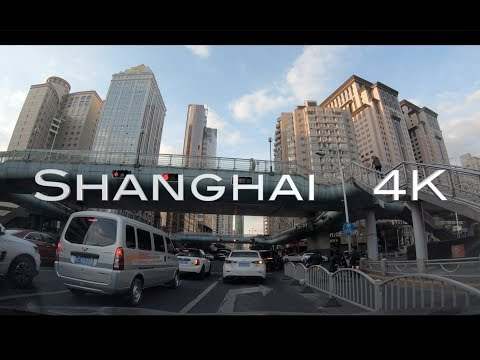

In [12]:
# This is the video we're going to process
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("ll8TgCZ0plk", width=500)
display(video)

In [13]:
# Install dependencies, download the video, and crop 5 seconds for processing
!pip install youtube-dl
!youtube-dl https://www.youtube.com/watch?v=ll8TgCZ0plk -f 22 -o video.mp4
!ffmpeg -i video.mp4 -t 00:00:06 -c:v copy video-clip.mp4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 43.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
[youtube] ll8TgCZ0plk: Downloading webpage
ERROR: Unable to extract uploader id; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.
/bin/bash: line 1: ffmpeg: command not found


Alternativa, dada pelo claude

In [14]:
# Install yt-dlp (more modern alternative to youtube-dl) and ffmpeg
!pip install yt-dlp
#--> sudo apt-get update && sudo apt-get install -y ffmpeg

# Download the video using yt-dlp
!yt-dlp https://www.youtube.com/watch?v=ll8TgCZ0plk -f 22 -o video.mp4

# Crop 6 seconds from the video
!ffmpeg -i video.mp4 -t 00:00:06 -c:v copy video-clip.mp4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 70.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
[youtube] Extracting URL: https://www.youtube.com/watch?v=ll8TgCZ0plk
[youtube] ll8TgCZ0plk: Downloading webpage
[youtube] ll8TgCZ0plk: Downloading tv client config
[youtube] ll8TgCZ0plk: Downloading player ab11fe69-main
[youtube] ll8TgCZ0plk: Downloading tv player API JSON
[youtube] ll8TgCZ0plk: Downloading ios player API JSON
[youtube] ll8TgCZ0plk: Downloading m3u8 information
ERROR: [youtube] ll8TgCZ0plk: Requested format is not available. Use --list-formats for a list of available formats
/bin/bash: line 1: ffmpeg: command not found


In [15]:
# Run frame-by-frame inference demo on this video (takes 3-4 minutes) with the "demo.py" tool we provided in the repo.
!git clone https://github.com/facebookresearch/detectron2
# Note: this is currently BROKEN due to missing codec. See https://github.com/facebookresearch/detectron2/issues/2901 for workaround.
%run detectron2/demo/demo.py --config-file detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml --video-input video-clip.mp4 --confidence-threshold 0.6 --output video-output.mkv \
  --opts MODEL.WEIGHTS detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl

Cloning into 'detectron2'...
remote: Enumerating objects: 15860, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 15860 (delta 38), reused 15 (delta 13), pack-reused 15793 (from 3)
Receiving objects: 100% (15860/15860), 6.41 MiB | 22.96 MiB/s, done.
Resolving deltas: 100% (11546/11546), done.


ModuleNotFoundError: No module named 'vision'

In [16]:
# Download the results
#from google.colab import files
#files.download('video-output.mkv')

In [17]:
# Option 1: Display video file path
import os
output_file = 'video-output.mkv'
print(f"Video saved to: {os.path.abspath(output_file)}")

# Option 2: Display a video frame from the output to verify it worked
import cv2
import matplotlib.pyplot as plt

def display_video_frame(video_path, frame_number=0):
    """Display a specific frame from a video file"""
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    
    if ret:
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Frame {frame_number} from {video_path}")
        plt.show()
    else:
        print(f"Could not read frame {frame_number} from {video_path}")

# Display the first frame of the output video
display_video_frame('video-output.mkv')

Video saved to: /home/pauloarbu/phpy/detectron2_working/notebooks/video-output.mkv
Could not read frame 0 from video-output.mkv
